### Look at: what is the relationship between residual R^2 and partial R^2?
Would expect them to be equal, if not very correlated

### CURRENT STATUS:
- Getting negative partial R^2s, implying R^2 of model without values > R^2 model with values. Don't know how this is possible. 
- In the full regression case also sometimes getting negative scores. 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)

In [2]:
OUTPUT_DIR = "/data/patrick_res/glm_2"
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)

In [3]:
positions = spike_utils.get_unit_positions(sessions)

### Load residual models

In [4]:
fb_type = "Response"

def load_glm(session, res_name):
    res = pd.read_pickle(os.path.join(OUTPUT_DIR, res_name))
    res["TimeIdxs"] = (res["TimeBins"] * 20).astype(int)
    res["session"] = session
    res["PseudoUnitID"] = int(session) * 100 + res.UnitID
    return res


def get_residual_glm_res(session):
    # res_name = f"{session}_glm_{fb_type}_residual_fr_{MODE}_{INTERVAL_SIZE}_{MODEL}_values.pickle"
    res_name = f"{session}_glm_{fb_type}_residual_fr_prev_trial_params_{EVENT}_{MODE}_{INTERVAL_SIZE}_{MODEL}_values.pickle"
    res = load_glm(session, res_name)
    res = res.rename(columns={"score": "residual_score"})
    return res

In [5]:
residual_glm_res = pd.concat(sessions.apply(lambda x: get_residual_glm_res(x.session_name), axis=1).values)

In [6]:
merged = pd.merge(residual_glm_res, positions, on="PseudoUnitID")
merged[merged.residual_score > 0.1].groupby("structure_level2").PseudoUnitID.nunique()

structure_level2
amygdala (Amy)                          4
anterior_cingulate_gyrus (ACgG)         1
basal_ganglia (BG)                      4
inferior_parietal_lobule (IPL)          3
inferior_temporal_cortex (ITC)         10
lateral_prefrontal_cortex (lat_PFC)     6
medial_pallium (MPal)                   2
motor_cortex (motor)                    2
superior_parietal_lobule (SPL)          1
thalamus (Thal)                         3
Name: PseudoUnitID, dtype: int64

### Load and calculate partial r^2

In [9]:
def get_additional_score(session):
    with_vals_path = f"{session}_glm_RPEGroup_normal_fr_{MODE}_{INTERVAL_SIZE}_{MODEL}_values.pickle"
    with_vals_res = load_glm(session, with_vals_path)
    with_vals_res = with_vals_res.rename(columns={"score": "with_vals_score"})
    coefs = [col for col in with_vals_res.columns if "_coef" in col]

    without_vals_path = f"{session}_glm_{MODE}_{INTERVAL_SIZE}_{MODEL}_feature_rpe_interaction.pickle"
    without_vals_res = load_glm(session, without_vals_path)
    without_vals_res = without_vals_res.rename(columns={"score": "without_vals_score"})

    coefs = [col for col in without_vals_res.columns if "_coef" in col]
    merged = pd.merge(with_vals_res, without_vals_res, on=["PseudoUnitID", "TimeIdxs"])
    merged["additional_score"] = 1 - (1 - merged["with_vals_score"]) / (1 - merged["without_vals_score"])
    # merged["additional_score"] = 
    return merged

In [7]:
partial_reses = pd.concat(sessions.apply(lambda x: get_additional_score(x.session_name), axis=1).values)

NameError: name 'get_additional_score' is not defined

In [ ]:
merged = pd.merge(partial_reses, residual_glm_res, on=["PseudoUnitID", "TimeIdxs"])
pos_merged = merged[merged.additional_score > 0]

In [8]:
len(pos_merged.PseudoUnitID.unique())

NameError: name 'pos_merged' is not defined

In [32]:
print(np.corrcoef(pos_merged.additional_score, pos_merged.residual_score)[0, 1])

0.31242508663228147


Text(0, 0.5, 'residual score')

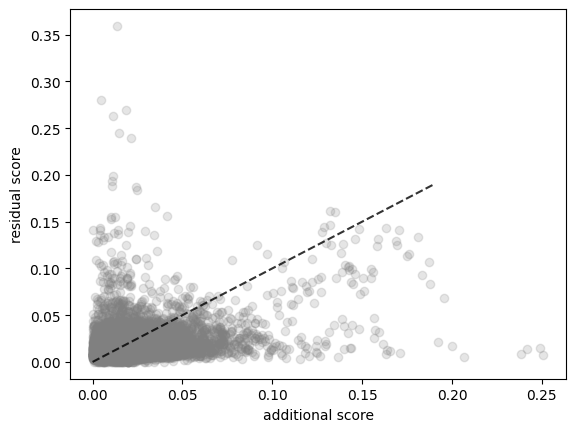

In [33]:
fig, ax = plt.subplots()
ax.scatter(pos_merged.additional_score, pos_merged.residual_score, alpha=0.2, color="gray")
ax.plot(np.arange(0, 0.2, 0.01), np.arange(0, 0.2, 0.01), linestyle="--", color="black", alpha=0.8)
ax.set_xlabel("additional score")
ax.set_ylabel("residual score")


In [11]:
pos_res = pd.merge(residual_glm_res, positions, on="PseudoUnitID")

In [12]:
pos_res[pos_res.residual_score > 0.1].sort_values(by="residual_score", ascending=False).PseudoUnitID

11026    2018092104
1898     2018091830
11025    2018092104
11027    2018092104
8740     2018092620
            ...    
3189     2018100217
9552     2018100400
3063     2018100211
9553     2018100400
9557     2018100400
Name: PseudoUnitID, Length: 90, dtype: int64

In [13]:
# good_units = pos_res.sort_values(by="residual_score", ascending=False)[:200].PseudoUnitID.unique()

In [14]:
# positions[positions.PseudoUnitID.isin(good_units)].manual_structure.unique()

In [15]:
good_units = pos_res[pos_res.residual_score > 0.1].PseudoUnitID.unique()

In [16]:
pos_res[pos_res.residual_score > 0.1].groupby("structure_level2").PseudoUnitID.nunique()

structure_level2
amygdala (Amy)                          4
anterior_cingulate_gyrus (ACgG)         1
basal_ganglia (BG)                      4
inferior_parietal_lobule (IPL)          3
inferior_temporal_cortex (ITC)         10
lateral_prefrontal_cortex (lat_PFC)     6
medial_pallium (MPal)                   2
motor_cortex (motor)                    2
superior_parietal_lobule (SPL)          1
thalamus (Thal)                         3
Name: PseudoUnitID, dtype: int64

In [60]:
# good_units = pos_res[(pos_res.structure_level3 == "hippocampal_formation (HF)")]
# good_units = good_units.sort_values(by="residual_score", ascending=False)[:20].PseudoUnitID.unique()

In [61]:
# good_units = pos_res[
#     (pos_res.residual_score > 0.1) & 
#     (pos_res.structure_level2 == "lateral_prefrontal_cortex (lat_PFC)")
# ].PseudoUnitID.unique()
good_units = pos_res[
    (pos_res.residual_score > 0.1) & 
    (pos_res.structure_level2 == "lateral_prefrontal_cortex (lat_PFC)")
].PseudoUnitID.unique()

In [62]:
pos_res[pos_res.PseudoUnitID.isin(good_units)].groupby("session_x").PseudoUnitID.nunique()

session_x
20180709    1
20180712    1
20180803    1
20180808    1
20180926    1
20181002    1
Name: PseudoUnitID, dtype: int64

In [64]:
pos_res[pos_res.PseudoUnitID.isin(good_units)].structure_level3.unique()

array(['dorsolateral_prefrontal_cortex (dlPFC)',
       'ventrolateral_prefrontal_cortex (vlPFC)'], dtype=object)

In [65]:
good_units

array([2018070904, 2018100208, 2018080805, 2018092610, 2018080329,
       2018071206])

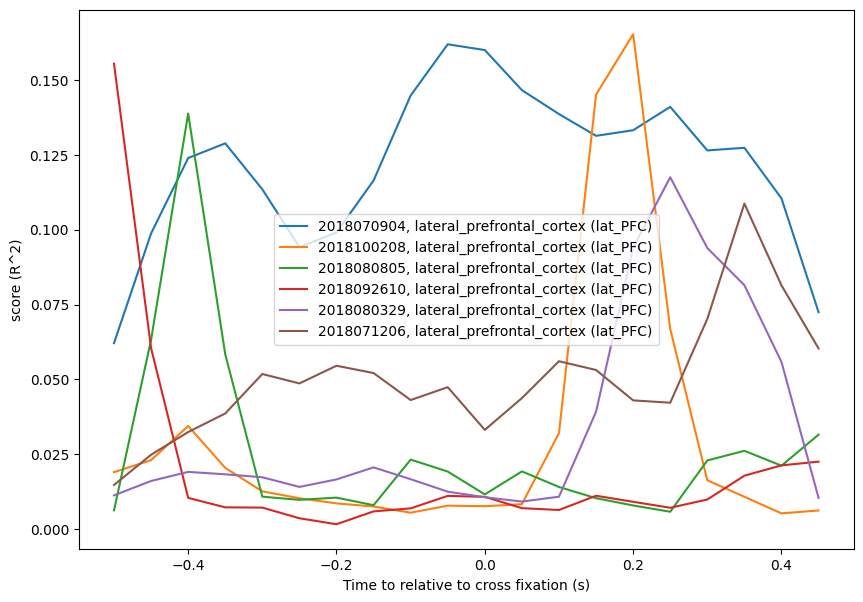

In [66]:
fig, ax = plt.subplots(figsize=(10, 7))
for unit in good_units:
    unit_res = pos_res[pos_res.PseudoUnitID == unit]
    structure =  unit_res.structure_level2.values[0]
    # color = 'red' if structure == "basal_ganglia (BG)" else 'blue'
    ax.plot(unit_res.TimeBins - 0.5, unit_res.residual_score, label=f"{unit}, {structure}")
ax.set_ylabel("score (R^2)")
ax.set_xlabel("Time to relative to cross fixation (s)")
ax.legend()

In [21]:
unit_res = pos_res[pos_res.PseudoUnitID == 2018092107]

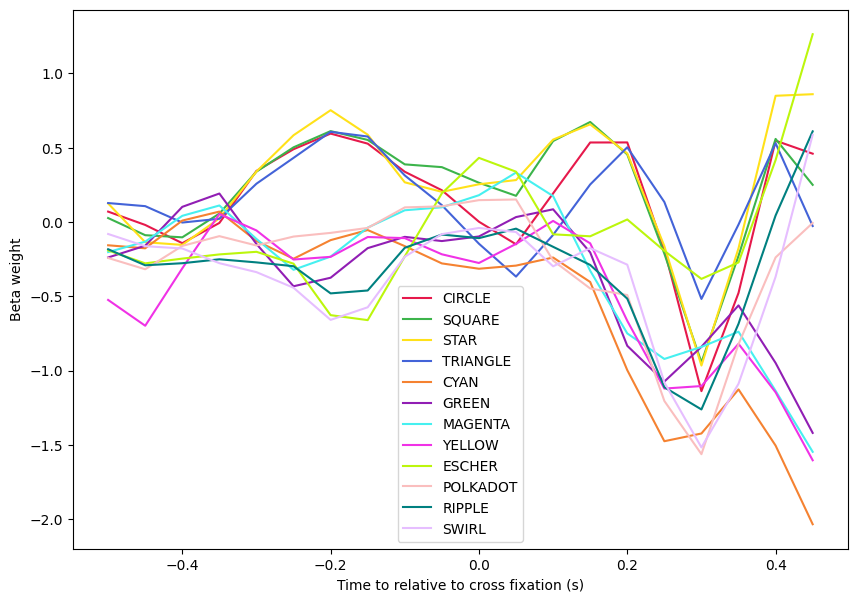

In [22]:
fig, ax = plt.subplots(figsize=(10, 7))
# 20 colors from https://sashamaps.net/docs/resources/20-colors/
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
for i, feat in enumerate(FEATURES):
    ax.plot(unit_res.TimeBins - 0.5, unit_res[feat + "Value_coef"], label=feat, color=colors[i])
ax.legend()
ax.set_ylabel("Beta weight")
ax.set_xlabel("Time to relative to cross fixation (s)")
ax.legend()

In [35]:
def calc_normed(group):
    session = group.name
    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    valid_beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(valid_beh)
    valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_feature_values_per_session(session, valid_beh)

    return glm_utils.calc_normalized_value_coefs(group, beh)

normed = pos_res.groupby("session_x").apply(calc_normed).reset_index()

/tmp/ipykernel_2416663/2337501274.py:14: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  normed = pos_res.groupby("session_x").apply(calc_normed).reset_index()


In [108]:
len(pos_res[pos_res.structure_level3 == "area_TE (TE)"].PseudoUnitID.unique())

67

In [46]:
pos_res.sort_values(by="residual_score", ascending=False)[["PseudoUnitID", "structure_level2", "structure_level3", "residual_score", "TimeBins"]][:50]

,PseudoUnitID,structure_level2,structure_level3,residual_score,TimeBins
11026,2018092104,inferior_temporal_cortex (ITC),area_TE (TE),0.359352,0.30
1898,2018091830,amygdala (Amy),subpallial_amygdala (spAmy),0.279602,0.90
11025,2018092104,inferior_temporal_cortex (ITC),area_TE (TE),0.269692,0.25
11027,2018092104,inferior_temporal_cortex (ITC),area_TE (TE),0.262557,0.35
8740,2018092620,inferior_temporal_cortex (ITC),fundus_of_the_superior_temporal_sulcus (STSf),0.244384,0.00
513,2018070925,motor_cortex (motor),lateral_motor_cortex (M1/PM),0.239791,0.65
1821,2018091827,inferior_parietal_lobule (IPL),lateral_intraparietal_sulcus (lat_IPS),0.221969,0.05
1820,2018091827,inferior_parietal_lobule (IPL),lateral_intraparietal_sulcus (lat_IPS),0.201473,0.00
2875,2018100201,inferior_temporal_cortex (ITC),area_TE (TE),0.199133,0.75
2849,2018100200,amygdala (Amy),pallial_amygdala (pAmy),0.193598,0.45


In [18]:
pos_res[
    (pos_res.residual_score > 0.1) & 
    (pos_res.structure_level2 == "inferior_temporal_cortex (ITC)")
].PseudoUnitID.unique()

array([2018091815, 2018100201, 2018100211, 2018100215, 2018100217,
       2018092620, 2018101002, 2018092104, 2018092107, 2018092115])